# Libraries

In [137]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import seaborn as sns

In [110]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Image Size and Directory Path

In [138]:
img_width, img_height = 224, 224
num_classes = 10
batch_size = 32
dataset_dir = "/content/drive/My Drive/Dataset_balance"

# Model Building

In [165]:
base_model = VGG16(weights = 'imagenet', include_top =False, input_shape=(img_width, img_height, 3))

In [166]:
for layer in base_model.layers:
  layer.trainable = False

In [167]:
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation = 'softmax')(x)

In [168]:
model = Model(
    inputs=base_model.input, 
    outputs=predictions
    )

In [169]:
model.compile(
    optimizer='adam', 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy']
    )

In [170]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

# Pre-Process Data using ImageDataGenerator

In [171]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
  )

In [172]:
train_data = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, "train"),
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 10040 images belonging to 10 classes.


In [173]:
train_data.class_indices

{'Bacterial_spot': 0,
 'Early_blight': 1,
 'Late_blight': 2,
 'Leaf_Mold': 3,
 'Septoria_leaf_spot': 4,
 'Spider_mites Two-spotted_spider_mite': 5,
 'Target_Spot': 6,
 'Tomato_Yellow_Leaf_Curl_Virus': 7,
 'Tomato_mosaic_virus': 8,
 'healthy': 9}

In [174]:
train_data.image_shape

(224, 224, 3)

In [175]:
val_datagen = ImageDataGenerator(rescale = 1./255)

In [176]:
val_data = val_datagen.flow_from_directory(
    os.path.join(dataset_dir, "val"),
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 1250 images belonging to 10 classes.


# Visualizing Data

<Axes: xlabel='labels', ylabel='count'>

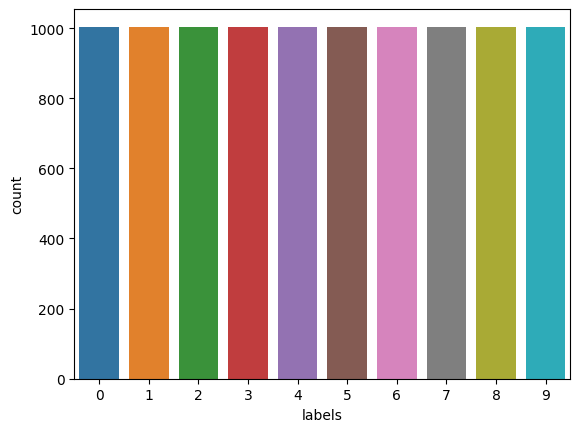

In [177]:
labelDf = pd.DataFrame(train_data.labels)
labelDf.rename(columns = {0:'labels'}, inplace = True)

sns.countplot(data=labelDf, x='labels')

In [178]:
train_data.samples

10040

# Model Checkpoint

In [179]:
from tensorflow.keras.callbacks import ModelCheckpoint

mc = ModelCheckpoint(filepath= "/content/drive/My Drive/vgg16.h5", 
                     monitor  = "val_accuracy", 
                     verbose = 1, 
                     save_best_only= True)

In [180]:
his = model.fit(
    train_data,
    steps_per_epoch = np.ceil(train_data.samples/batch_size),
    epochs = 40,
    validation_data = val_data,
    callbacks = [mc]
)

Epoch 1/40
314/314 [==============================] - ETA: 0s - loss: 1.3134 - accuracy: 0.7167
Epoch 1: val_accuracy improved from -inf to 0.81360, saving model to /content/drive/My Drive/vgg16.h5
314/314 [==============================] - 53s 162ms/step - loss: 1.3134 - accuracy: 0.7167 - val_loss: 0.5152 - val_accuracy: 0.8136
Epoch 2/40
314/314 [==============================] - ETA: 0s - loss: 0.2889 - accuracy: 0.9022
Epoch 2: val_accuracy improved from 0.81360 to 0.86000, saving model to /content/drive/My Drive/vgg16.h5
314/314 [==============================] - 52s 165ms/step - loss: 0.2889 - accuracy: 0.9022 - val_loss: 0.4405 - val_accuracy: 0.8600
Epoch 3/40
314/314 [==============================] - ETA: 0s - loss: 0.1515 - accuracy: 0.9500
Epoch 3: val_accuracy did not improve from 0.86000
314/314 [==============================] - 48s 153ms/step - loss: 0.1515 - accuracy: 0.9500 - val_loss: 0.6036 - val_accuracy: 0.8352
Epoch 4/40
314/314 [==============================] 

In [181]:
from tensorflow.keras.models import load_model

In [182]:
model = load_model("/content/drive/My Drive/vgg16.h5")

In [183]:
model.get_metrics_result()

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}

In [184]:
h = his.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

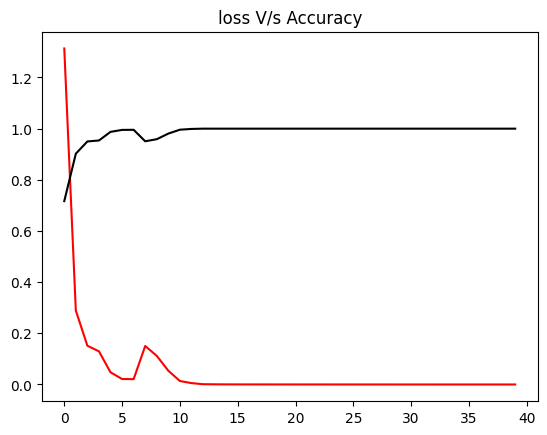

In [185]:
plt.plot(h['loss'], "r")
plt.plot(h['accuracy'], "k")
plt.title("loss V/s Accuracy")
plt.show()

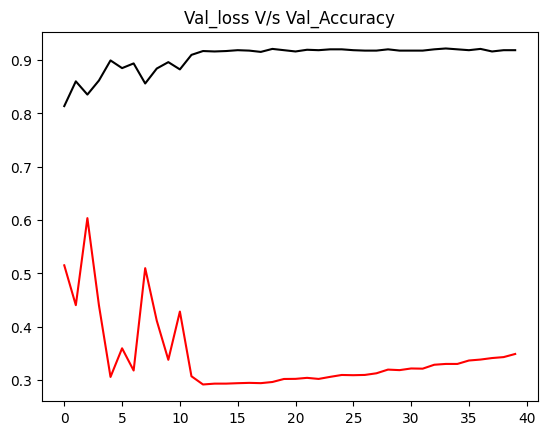

In [186]:
plt.plot(h['val_loss'], "r")
plt.plot(h['val_accuracy'], "k")
plt.title("Val_loss V/s Val_Accuracy")
plt.show()

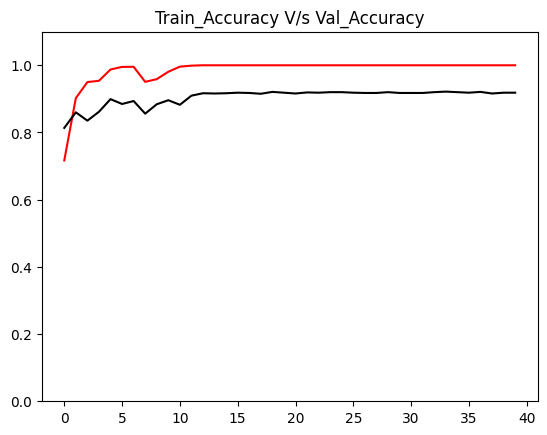

In [188]:
plt.plot(h['accuracy'], "r")
plt.plot(h['val_accuracy'], "k")
plt.ylim((0, 1.1))
plt.title("Train_Accuracy V/s Val_Accuracy")
plt.show()

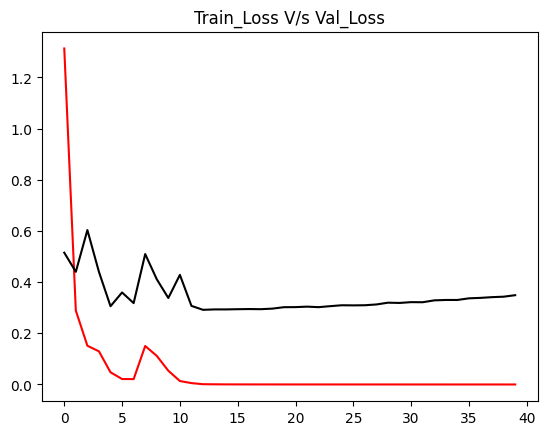

In [189]:
plt.plot(h['loss'], "r")
plt.plot(h['val_loss'], "k")
plt.title("Train_Loss V/s Val_Loss")
plt.show()